In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN

In [44]:
rng = np.random.RandomState(42)
def frequency_generator(N,min_period,max_period,n_changepoints):
    """returns a random step function with N changepoints
       and a sine wave signal that changes its frequency at
       each such step, in the limits given by min_ and max_period."""
    # vector of random indices < N, padded with 0 and N at the ends:
    changepoints = np.insert(np.sort(rng.randint(0,N,n_changepoints)),[0,n_changepoints],[0,N])
    # list of interval boundaries between which the control sequence should be constant:
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    # populate a control sequence
    f1 = np.zeros((N,1))
    f2 = np.zeros((N,1))
    for (t0,t1) in const_intervals:
        f1[t0:t1] = rng.rand()
        f2[t0:t1] = rng.rand()
        
    
    periods = f1 * (max_period - min_period) + max_period
    # # run time through a sine, while changing the period length
    frequency_output = np.zeros((N,1))
    z = 0
    for i in range(N):
        z = z + 2 * np.pi / periods[i]
        frequency_output[i] = (np.sin(z) + 1)/2
    return np.hstack([np.ones((N,1)),frequency_output]),1-f1


N = 10000 # signal length
min_period = 2
max_period = 10
n_changepoints = int(N/200)
frequency_control,frequency_output = frequency_generator(N,min_period,max_period,n_changepoints)

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = frequency_control[:traintest_cutoff],frequency_output[:traintest_cutoff]
test_ctrl, test_output  = frequency_control[traintest_cutoff:],frequency_output[traintest_cutoff:]

In [45]:
esn = ESN(n_inputs = 2,
          n_outputs = 1,
          n_reservoir = 100,
          spectral_radius = 0.25,
          sparsity = 0.95,
          noise = 0.001,
          input_shift = [0,0],
          input_scaling = [0.01, 3],
          teacher_scaling = 1.12,
          teacher_shift = -0.7,
          out_activation = np.tanh,
          inverse_out_activation = np.arctanh,
          random_state = rng,
          silent = False)

pred_train = esn.fit(train_ctrl,train_output)

print("test error:")
pred_test = esn.predict(test_ctrl)
print(np.sqrt(np.mean((pred_test - test_output)**2)))

harvesting states...
fitting...
training error:
0.027045133023280453
test error:
0.07346395470241933


In [42]:
import plotly.express as px
fig = px.line(train_ctrl[:,1])
fig.show(renderer='browser')

(-0.1, 1.1)

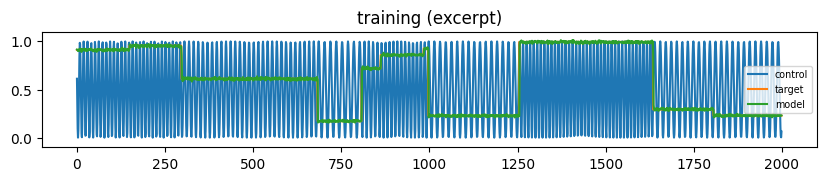

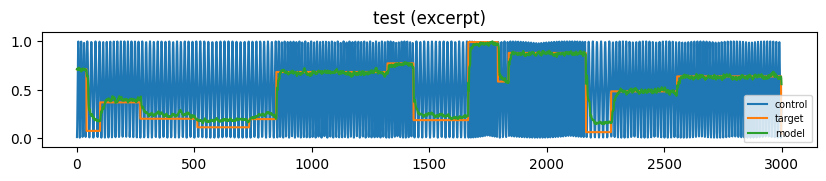

In [46]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))
plt.figure(figsize=(10,1.5))
plt.plot(train_ctrl[window_tr,1],label='control')
plt.plot(train_output[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
plt.ylim([-0.1,1.1])

plt.figure(figsize=(10,1.5))
plt.plot(test_ctrl[:,1],label='control')
plt.plot(test_output,label='target')
plt.plot(pred_test,label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
plt.ylim([-0.1,1.1])

What we see is that we can't see much, except that the amplitude is systematically too small (any ideas why that is?).

So let's look at a few spectrograms to see how the frequency spectrum of these signals changes over time.

Text(0.5, 1.0, 'test: model')

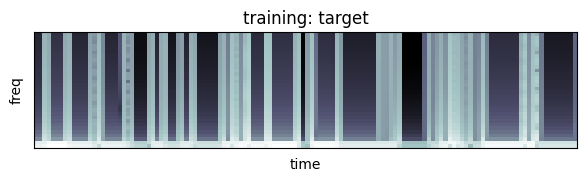

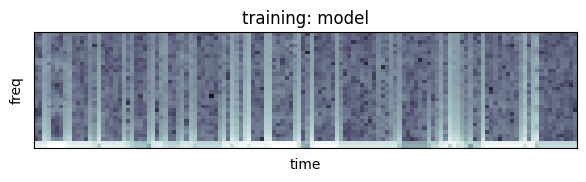

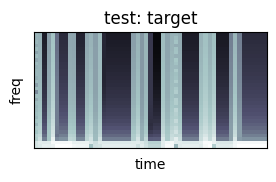

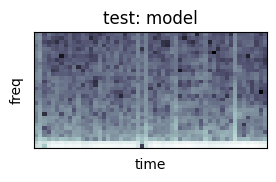

In [24]:
def draw_spectogram(data):
    plt.specgram(data,Fs=4,NFFT=256,noverlap=150,cmap=plt.cm.bone,detrend=lambda x:(x-0.5))
    plt.gca().autoscale('x')
    plt.ylim([0,0.5])
    plt.ylabel("freq")
    plt.yticks([])
    plt.xlabel("time")
    plt.xticks([])

plt.figure(figsize=(7,1.5))
draw_spectogram(train_output.flatten())
plt.title("training: target")
plt.figure(figsize=(7,1.5))
draw_spectogram(pred_train.flatten())
plt.title("training: model")

plt.figure(figsize=(3,1.5))
draw_spectogram(test_output.flatten())
plt.title("test: target")
plt.figure(figsize=(3,1.5))
draw_spectogram(pred_test.flatten())
plt.title("test: model")

It's a frequency generator!